In [3]:
import os
import numpy as np
import rawpy as raw
import cv2 as cv
import rawpy.enhance
import matplotlib.pyplot as mp
from jupyterthemes import jtplot

In [4]:
jtplot.reset()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [40]:
class AWBAAET:
    
    def contrastStretchMod(self, img, p=0.05):
        try:
            img_type = self.datatype
        except AttributeError:
            img_type = str(img.dtype)
        if 'int' in img_type:
            img = img.astype('float64') / np.iinfo(img_type).max
        img_cs = img.copy()
        for i in range(img.shape[2]):
            lo, hi = np.percentile(img.T[i], p), np.percentile(img.T[i], 100-p)
            img_cs.T[i] = (img.T[i] - lo)/(hi - lo) * img.T[i].max() + img.T[i].min()
        img_cs = (img_cs * np.iinfo(img_type).max).astype(img_type)
        return img_cs


    def grayWorld(self, img):
        try:
            img_type = self.datatype
        except AttributeError:
            img_type = str(img.dtype)
        if 'int' in img_type:
            img = img.astype('float64') / np.iinfo(img_type).max
        img_gw = img.copy()
        Bave, Gave, Rave = [img.T[i].mean() for i in range(img.shape[2])]
        Aave = np.mean([Bave, Gave, Rave])
        for i in range(img.shape[2]):
            img_gw.T[i] = img_gw.T[i] * Aave/img.T[i].mean()
        img_gw = (img_gw * np.iinfo(img_type).max).astype(img_type)
        return img_gw
    
    
    def grayWorldMod(self, img):
        try:
            img_type = self.datatype
        except AttributeError:
            img_type = str(img.dtype)
        if 'int' in img_type:
            img = img.astype('float64') / np.iinfo(img_type).max
        img_gw = img.copy()
        Bave, Gave, Rave = [img.T[i].mean() for i in range(img.shape[2])]
        Aave = np.mean([Bave, Gave, Rave])
        for i in range(img.shape[2]):
            img_gw.T[i] = img_gw.T[i] + (Aave - img_gw.T[i].mean())
        img_gw = (img_gw * np.iinfo(img_type).max).astype(img_type)
        return img_gw


    def weightDecision(self, img, n=200):
        img_type = self.datatype
        if 'int' in img_type:
            img = img.astype('float32') / np.iinfo(img_type).max
        channel_std = np.array([img.T[i].std() for i in range(img.shape[2])])
        img = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
        x = abs(img.T[2].mean() - img.T[1].mean())
#         weight = n*x/(max(img.T[2].mean(), img.T[1].mean()))
        weight = (abs(img.T[2].mean() - img.T[1].mean()) + abs(max(channel_std) - min(channel_std)))/n
        self.weight = weight
        return weight


    def main(self, img, p=0.05, n=200):
        if type(img) == str:
            img = cv.imread(img)
        elif type(img) == np.ndarray:
            pass
        else:
            raise NotImplementedError
        self.img = img
        self.datatype = str(img.dtype)
        img_hs = self.contrastStretchMod(img, p)
        img_gw = self.grayWorld(img)
        w = self.weightDecision(img, n)
        out = w*img_hs + (1 - w)*img_gw
        out = out.astype(self.datatype)
        self.out = out

In [83]:
class MergeGrays:
    def __init__(self, true_color, gray_channels, save_true=False, save_truename=None):
        self.grays = gray_channels
        self.true = true_color
        
        rawdir = 'raw/'
        raw_img = raw.imread(rawdir + self.true)
        y_true = raw_img.postprocess(use_camera_wb=True, 
                                     output_bps=8)
        y_true = cv.resize(y_true, (2250, 1500))
        if save_true:
            cv.imwrite(save_truename, y_true[:,:,::-1])
        self.orig = y_true

        
    def merge(self, save=False, savename=None):
        self.img = np.dstack([cv.imread(f, 0) for f in self.grays])
        if save:
            cv.imwrite(savename, self.img[:,:,::-1])
            
    
    def whiteBalance(self, method, save=False, savename=None, **method_kwargs):
        awb = AWBAAET()
        if method == 'contrast_stretch':
            img_wb = awb.contrastStretchMod(self.img, **method_kwargs)
        elif method == 'gray_world':
            img_wb = awb.grayWorld(self.img)
        elif method == 'combine':
            awb.main(self.img, **method_kwargs)
            img_wb = awb.out
        else:
            raise NotImplementedError
        
        if save:
            cv.imwrite(savename, img_wb[:,:,::-1])

        self.img_wb = img_wb
        
        
    def plot_compare(self):
        fig = mp.figure(figsize=(16, 9))

        ax = fig.add_subplot(131)
        ax.imshow(self.orig, vmin=0, vmax=255)
        ax.grid(0)
        ax.axis('off')
        ax.set_title('true')

        ax = fig.add_subplot(132)
        ax.imshow(self.img, vmin=0, vmax=255)
        ax.grid(0)
        ax.axis('off')
        ax.set_title('merge grays')

        ax = fig.add_subplot(133)
        ax.imshow(self.img_wb, vmin=0, vmax=255)
        ax.grid(0)
        ax.axis('off')
        ax.set_title('white balanced')

        mp.tight_layout()
        mp.show()

In [89]:
notes = ['dsc_6237.png', 'dsc_6238.png', 'dsc_6239.png']
redbook = ['dsc_6244.png', 'dsc_6245.png', 'dsc_6246.png']
greenbook = ['dsc_6257.png', 'dsc_6258.png', 'dsc_6259.png']
bluebook = ['dsc_6251.png', 'dsc_6252.png', 'dsc_6253.png']

refs = ['dsc_6231.nef', 'dsc_6241.nef', 'dsc_6249.nef', 'dsc_6255.nef']
fs = [notes, redbook, greenbook, bluebook]

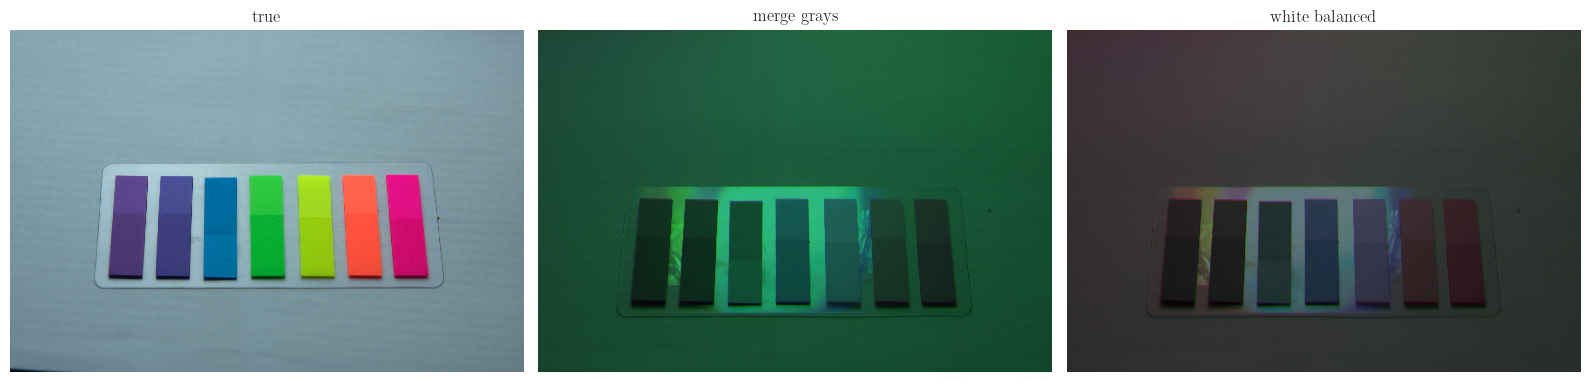

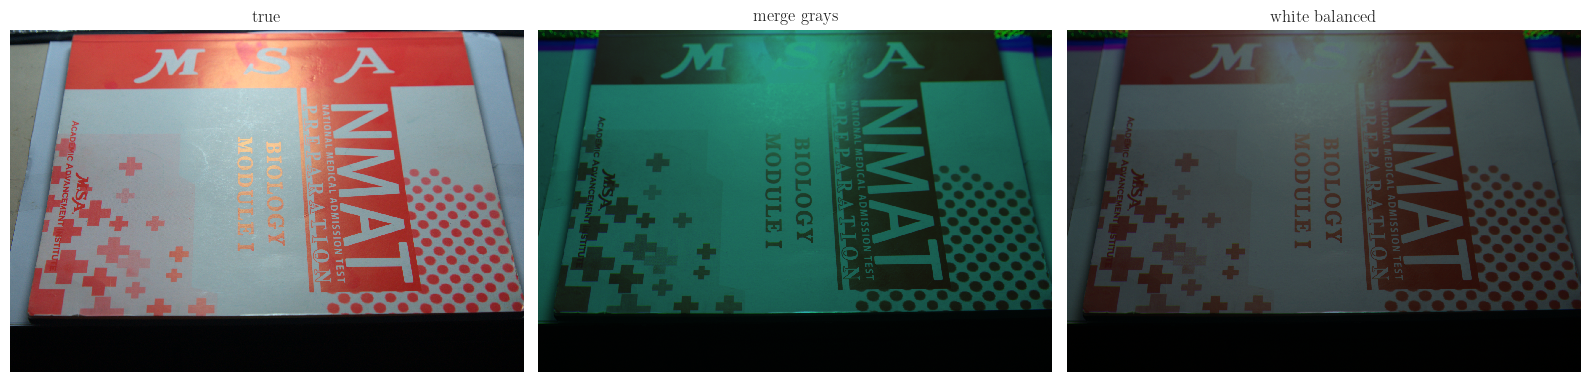

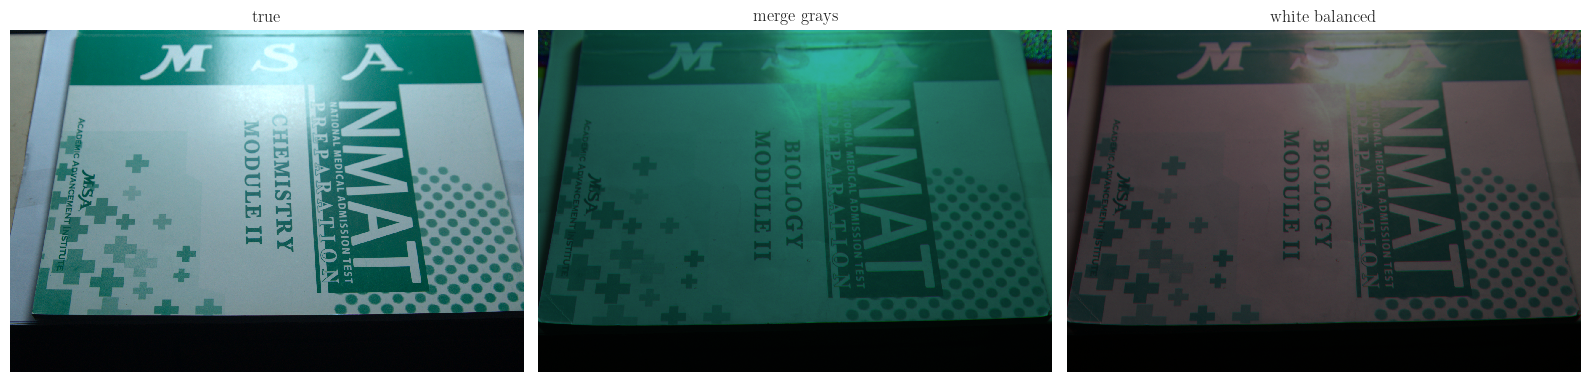

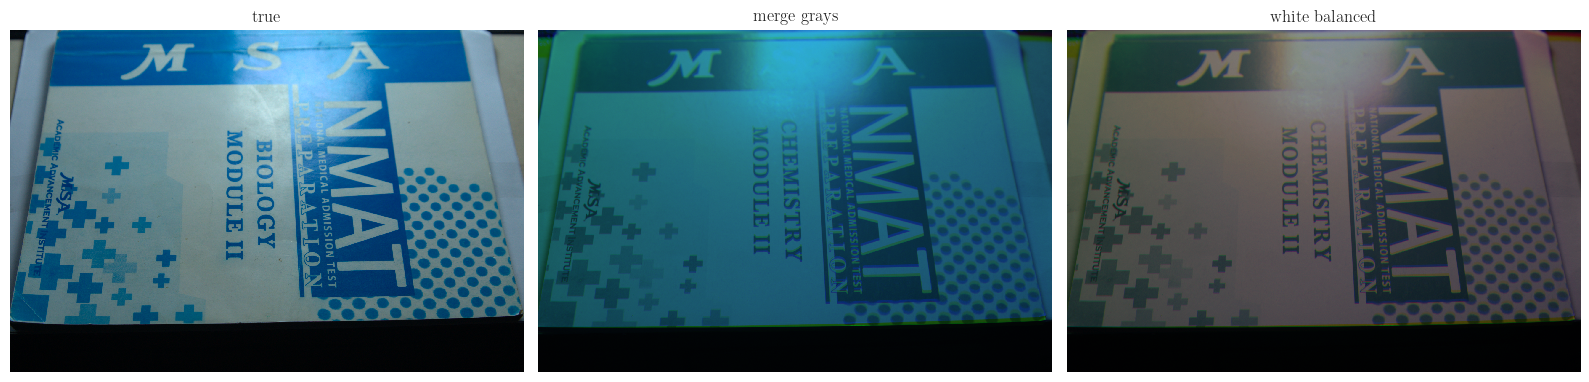

In [90]:
for i in range(len(refs)):
    cap = MergeGrays(refs[i], fs[i])
    cap.merge()
    cap.whiteBalance('combine')
    cap.plot_compare()